In [1]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data


In [2]:
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test
%store -r X_train_scaled
%store -r X_test_scaled 
%store -r X_train_stand
%store -r X_test_stand

target_names = ["CONFIRMED", "FALSE POSITIVE", "CANDIDATE"]
feature_names = X_train.columns

Data normalization or standardization is not performed since the performace of random forest model is not affected by data normalization/standardization

# Decision Tree

In [3]:
from sklearn.metrics import classification_report
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train)

1.0

The default decison tree model causes overfitting

# Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics

In [6]:
rf0 = RandomForestClassifier(random_state=10)
print(f"The cross-validated accuracy for unprocessed training set:\n{round(cross_val_score(rf0,X_train,y_train,scoring='accuracy', cv=5).mean()*100,2)}%")

The cross-validated accuracy for unprocessed training set:
89.26%


In [59]:
cross_val_score(rf0,X_train,y_train,scoring='accuracy', cv=5).mean()

0.8926192884535619

In [61]:
rf0 = RandomForestClassifier(oob_score = True, random_state=10)
rf0.fit(X_train, y_train)
print(f"Out of Bag Score: {rf0.oob_score_}")
y_predprob = rf0.predict_proba(X_train) # the probabilities of each class
print(f"AUC Score (Train):{metrics.roc_auc_score(y_train, rf0.predict_proba(X_train), multi_class='ovr')}")

Out of Bag Score: 0.8928094602326913
AUC Score (Train):1.0


The random forest model with default setting achieves a cross-validated accuracy of 89.26%.

# Model Tuning

### 1. n_estimators
First, optimize the model by tuning the number of estimators (number of trees in forest)

In [55]:
# the overall random forest model gets more complex
param_test1 = {'n_estimators':range(10,201,10)} # default: 100
grid1 = GridSearchCV(estimator = RandomForestClassifier(random_state=10, 
#                                                         default: 
#                                                         min_samples_split=  2
#                                                         min_samples_leaf= 1
#                                                         max_depth= none
                                                        max_features='sqrt'), # auto, same as sqrt 
                       param_grid = param_test1,cv=5, n_jobs = -1)

grid1.fit(X_train, y_train)
grid1.cv_results_['mean_test_score'], grid1.best_params_, grid1.best_score_

(array([0.87697789, 0.88823034, 0.89147425, 0.89261983, 0.89223834,
        0.89223797, 0.8928094 , 0.89357294, 0.89204732, 0.89261929,
        0.89357403, 0.89395498, 0.89319235, 0.89548061, 0.89509911,
        0.89433648, 0.8947178 , 0.89586302, 0.89529068, 0.89510039]),
 {'n_estimators': 180},
 0.8958630174866649)

According to the optimization results, the best hyperparameter for `n_estimators` is 180. The resulted cross-validated accuracy is 89.58%. Compared with the default setting where `n_estimator` is 100, the tuned model with `n_estimator` of 180 increases the cross-validated accuracy.

### 2. max_depth
Then, optimze the model by tuning the `max_depth`

In [65]:
# make the model simpler
param_test2 = {'max_depth':range(2,51,2)} # default = none
grid2 = GridSearchCV(estimator = RandomForestClassifier(random_state = 10,
                                                        n_estimators = 180,  
                                                        max_features = 'sqrt'),
                       param_grid = param_test2, cv=5, n_jobs = -1)

grid2.fit(X_train, y_train)
grid2.cv_results_['mean_test_score'], grid2.best_params_, grid2.best_score_

(array([0.74537746, 0.85561767, 0.87412003, 0.88270327, 0.88365728,
        0.88975997, 0.89243045, 0.89128487, 0.89300151, 0.89281122,
        0.89414692, 0.89433721, 0.89433794, 0.89605349, 0.89529104,
        0.89529068, 0.89529104, 0.89586302, 0.89586302, 0.89586302,
        0.89586302, 0.89586302, 0.89586302, 0.89586302, 0.89586302]),
 {'max_depth': 28},
 0.8960534933306166)

In [66]:
param_test2_1 = {'max_depth':[27,28,29]} # default = none
grid2_1 = GridSearchCV(estimator = RandomForestClassifier(random_state = 10,
                                                        n_estimators = 180,  
                                                        max_features = 'sqrt'),
                       param_grid = param_test2_1, cv=5, n_jobs = -1)

grid2_1.fit(X_train, y_train)
grid2_1.cv_results_['mean_test_score'], grid2_1.best_params_, grid2_1.best_score_

(array([0.89452769, 0.89605349, 0.89376505]),
 {'max_depth': 28},
 0.8960534933306166)

The best `max_depth` estimator is 28. The resulted cross-validated accuracy is 89.60%, which is increased compared to the default model where `max_depth` is None. Introducing the `max_depth` may make the model simpler, weakening the overfitting effects. 

As introducing restriction on `max_depth` simplifies the model and increases the accuracy, we want to try to simplify the model further by adding limitations into `min_samples_leaf`.

### 3. min_samples_leaf

Then, optimze the model by tuning the `min_samples_leaf`

In [11]:
# make the model simpler
param_test3 = {'min_samples_leaf': range(1, 1+10, 1)}
grid3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 180,
                                                        random_state = 10,
                                                        max_depth = 28
                                                           ), 
                       param_grid = param_test3,cv=5, n_jobs = -1)

grid3.fit(X_train, y_train)
grid3.cv_results_['mean_test_score'], grid3.best_params_, grid3.best_score_

(array([0.89605349, 0.89357476, 0.89204804, 0.8914768 , 0.88861657,
        0.89014274, 0.88632795, 0.88384776, 0.88422907, 0.88155877]),
 {'min_samples_leaf': 1},
 0.8960534933306166)

The accuracy reaches it's relative best  when the `min_samples_leaf` is 1 (default). Increasing `min_samples_leaf` (simplyfying the model) does not improve the model performace. As a result, we next consider making the model more complex by increasing the `max_features`.

### 4. max_features 
Then, optimze the model by tuning the `max_features`

In [20]:
# make the model more complex
param_test4 = {'max_features':range(6,35,2)}
grid4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 180,
                                                        random_state = 10,
                                                        max_depth = 28,
                                                        min_samples_leaf = 1
                                                           ), 
                       param_grid = param_test4,cv=5, n_jobs = -1)

grid4.fit(X_train, y_train)
grid4.cv_results_['mean_test_score'], grid4.best_params_, grid4.best_score_

(array([0.89605349, 0.8994877 , 0.8991062 , 0.90253859, 0.90559129,
        0.90196661, 0.90406458, 0.90349133, 0.90406348, 0.90387319,
        0.90082176, 0.90215691, 0.90158475, 0.89948479, 0.90158402]),
 {'max_features': 14},
 0.905591293780336)

In [21]:
param_test4_1 = {'max_features':[13,14,15]}
grid4_1 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 180,
                                                        random_state = 10,
                                                        max_depth = 28,
                                                        min_samples_leaf = 1
                                                           ), 
                       param_grid = param_test4_1,cv=5, n_jobs = -1)

grid4_1.fit(X_train, y_train)
grid4_1.cv_results_['mean_test_score'], grid4_1.best_params_, grid4.best_score_

(array([0.90616254, 0.90559129, 0.90273015]),
 {'max_features': 13},
 0.905591293780336)

The best accuracy is increased from 89.60% to 90.62%. The best `max_features` is increased to 13, compared to the default `max_features` of 6 (sqrt(# of features)), which makes the model more complicated. That means the model may be optimzed further by making the model more complex.

Finally, we get the optimzed random forest model.

In [5]:
tuned_rf = RandomForestClassifier(random_state=10,
                                  n_estimators = 180,
                                  max_depth = 28,
                                  min_samples_leaf = 1,
                                  max_features = 13)
print(f"The cross-validated accuracy based on the tuned random forest model:\n{round(cross_val_score(tuned_rf,X_train,y_train,scoring='accuracy', cv=5).mean()*100,2)}%")

The cross-validated accuracy based on the tuned random forest model:
90.62%


## Feature importance

In [6]:
tuned_rf.fit(X_train, y_train)
sorted(zip(tuned_rf.feature_importances_, feature_names), reverse=True)

[(0.15069536732575972, 'koi_fpflag_nt'),
 (0.14146587965034763, 'koi_fpflag_co'),
 (0.10165603082702997, 'koi_fpflag_ss'),
 (0.07509275910625265, 'koi_model_snr'),
 (0.055660235676295494, 'koi_prad'),
 (0.04387305358173222, 'koi_fpflag_ec'),
 (0.03346613450525558, 'koi_duration_err2'),
 (0.0261491978703565, 'koi_prad_err2'),
 (0.025536595260736487, 'koi_duration_err1'),
 (0.024285081660675167, 'koi_prad_err1'),
 (0.022783397349897094, 'koi_duration'),
 (0.022623653426896373, 'koi_steff_err1'),
 (0.01855670186467603, 'koi_time0bk_err1'),
 (0.017430290265402836, 'koi_period'),
 (0.015991710668787674, 'koi_impact'),
 (0.013845945039761049, 'koi_steff_err2'),
 (0.013496822210222047, 'koi_time0bk_err2'),
 (0.012674385496604176, 'koi_period_err1'),
 (0.011678622926369998, 'koi_time0bk'),
 (0.011264688173610912, 'dec'),
 (0.010867862328096304, 'koi_period_err2'),
 (0.010691724215102219, 'ra'),
 (0.010356938326003923, 'koi_insol_err1'),
 (0.009781724768195643, 'koi_depth_err1'),
 (0.0093041233

In [23]:
feature_list = list(sorted(zip(tuned_rf.feature_importances_, feature_names),reverse = True))
feature_counts = len(feature_list)

important_features = []
for i in range(feature_counts):
    if feature_list[i][0] > 0.01:
        important_features.append(feature_list[i][1])

important_features

['koi_fpflag_nt',
 'koi_fpflag_co',
 'koi_fpflag_ss',
 'koi_model_snr',
 'koi_prad',
 'koi_fpflag_ec',
 'koi_duration_err2',
 'koi_prad_err2',
 'koi_duration_err1',
 'koi_prad_err1',
 'koi_duration',
 'koi_steff_err1',
 'koi_time0bk_err1',
 'koi_period',
 'koi_impact',
 'koi_steff_err2',
 'koi_time0bk_err2',
 'koi_period_err1',
 'koi_time0bk',
 'dec',
 'koi_period_err2',
 'ra',
 'koi_insol_err1']

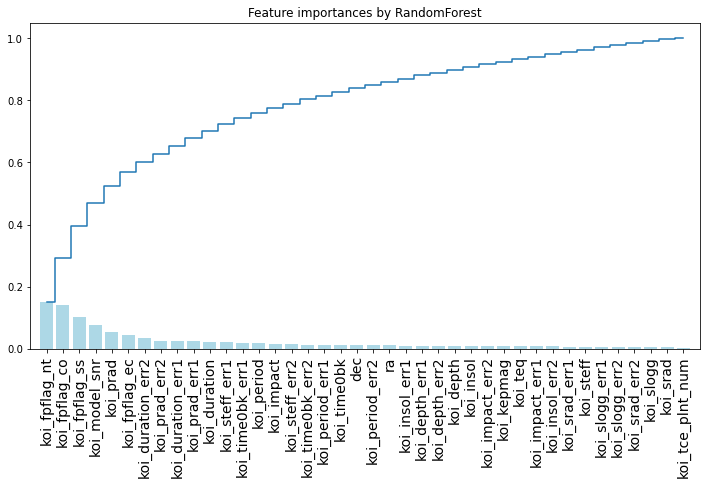

In [7]:
importances = tuned_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by RandomForest")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feature_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

# Save the optimzed random forest model

In [35]:
import joblib
filename = "random_forest.sav"
joblib.dump(tuned_rf, filename)

['random_forest.sav']